# Applied Data Science 2 - Keras Assignment - 2023A

In this assignment you will be building a script to classify movie posters. The assignment is broken up into sections and you need to complete each section successively. The sections are:

1. Data Processing
2. Model Definition
3. Model Training
4. Model Evaluation

In addition to this coding exercise, you will also need to write a 1-2 page report analysing and critically evaluating you models results.

In [ ]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns

2024-04-30 11:27:51.026187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 11:27:51.026245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 11:27:51.064772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 11:27:51.148988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 11:27:52.064094: W tensorflow/compiler/tf2

In [ ]:
# CodeGrade Tag Init1
# Do not edit, remove, or copy this cell

#from google.colab import drive
#drive.mount('/content/drive')

# Data Processing



In [ ]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
#! mkdir /tmp/Multi_Label_dataset
#! rsync -ah --info=progress2 /content/drive/MyDrive/Multi_Label_dataset/Images /tmp/Multi_Label_dataset/

In [ ]:
# CodeGrade Tag DataProc
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multi_Label_dataset/train.csv"
dataset = pd.read_csv("/content/drive/MyDrive/Multi_Label_dataset/train.csv")

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre'],axis=1).columns)

# Build the file locations for the images
img_loc = "/tmp/Multi_Label_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]


# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

# Create the initial datasets
train_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
test_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

2024-04-30 11:28:00.227983: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 11:28:00.348984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 11:28:00.349032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 11:28:00.351187: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 11:28:00.351344: I external/local_xla/xla/stream_executor

**Create a function called "img_process" converts the images to float32 datatype and resizes them to 64x64 pixels.**

In [ ]:
# CodeGrade Tag Ex1a
### Write a function called img_process, which takes in the image and label as
### inputs, converts the data type of the image to tf.float32, resizes the
### image to (64, 64), and finally returns the image and labels.

def img_process(image, label):
    # Converting the image to tf.float32
    image_float  = tf.image.convert_image_dtype(image, 'float32')
    # Resizing the image
    image_resize = tf.image.resize(image_float, (64, 64))
    return image_resize, label

**Using the tf.data API, load in the training and validation data. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [ ]:
# CodeGrade Tag Ex1b
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64. Use techniques like caching and
### prefetching to efficiently load the data.


ts_batch_size = 64

mv_train_ds = (train_list_ds .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE).batch(ts_batch_size)\
            .map(img_process, num_parallel_calls=tf.data.AUTOTUNE).cache()\
            .shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE))

mv_val_ds = (test_list_ds\
          .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE).batch(ts_batch_size)\
          .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)\
          .cache().prefetch(tf.data.AUTOTUNE))


# Model Definition

**Using the Keras Functional API, create a convolutional neural network with the architecture show in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [ ]:
# CodeGrade Tag Ex2a
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

# Define dropout rates
dropout_rate_conv = 0.2
dropout_rate_dense = 0.5


# Input layer
input_layer = tf.keras.layers.Input(shape=(64, 64, 3), name='Input')

# Convolutional layers
conv0_layer = tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2),
                                     activation='relu', padding='same',
                                     name='Conv0')(input_layer)
drop1_layer = tf.keras.layers.Dropout(dropout_rate_conv, name='Drop1')(conv0_layer)
conv1_layer = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     padding='same', name='Conv1')(drop1_layer)
conv2_layer = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     padding='same', name='Conv2')(conv1_layer)
drop2_layer = tf.keras.layers.Dropout(dropout_rate_conv, name='Drop2')(conv2_layer)
pool1_layer = tf.keras.layers.MaxPooling2D((2, 2), name='Pool1')(drop2_layer)
conv3_layer = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                     padding='same', name='Conv3')(pool1_layer)
conv4_layer = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                     padding='same', name='Conv4')(conv3_layer)
drop3_layer = tf.keras.layers.Dropout(dropout_rate_conv, name='Drop3')(conv4_layer)
pool2_layer = tf.keras.layers.MaxPooling2D((2, 2), name='Pool2')(drop3_layer)
conv5_layer = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                     padding='same', name='Conv5')(pool2_layer)
conv6_layer = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                     padding='same', name='Conv6')(conv5_layer)
drop4_layer = tf.keras.layers.Dropout(dropout_rate_conv, name='Drop4')(conv6_layer)
pool3_layer = tf.keras.layers.MaxPooling2D((2, 2), name='Pool3')(drop4_layer)

# Flatten layer
flatten_layer = tf.keras.layers.Flatten(name='Flat')(pool3_layer)

# Fully connected layers
fc1_layer = tf.keras.layers.Dense(1024, activation='relu', name='FC1')(flatten_layer)
drop5_layer = tf.keras.layers.Dropout(dropout_rate_dense, name='Drop5')(fc1_layer)
fc2_layer = tf.keras.layers.Dense(1024, activation='relu', name='FC2')(drop5_layer)
drop6_layer = tf.keras.layers.Dropout(dropout_rate_dense, name='Drop6')(fc2_layer)

# Output layer
output_layer = tf.keras.layers.Dense(25, activation='sigmoid', name='Output')(drop6_layer)

# Define the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='model')


In [ ]:
# CodeGrade Tag Ex2b
### Print the model summary and confirm is has the same architecture as the one
### provided.

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0     

**Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [ ]:
# CodeGrade Tag Ex2c
### Compile the model using the Adam Optimizer, binary crossentropy loss, and
### precision and recall metrics.

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
               metrics=[tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

# Model Training

**Create a Model Checkpoint Callback that saves the weights of the best performing epoch, based on the validation accuracy.**

In [ ]:
# CodeGrade Tag Ex3a
### Create a ModelCheckpoint callback to store the bext weights from the model,
### based on the validation accuracy. Call this callback "checkpoint_callback"

checkpoint_filepath = '/content/checkpoint'

# Define the checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                      filepath=checkpoint_filepath , monitor='val_loss', save_best_only=True,
                                      save_weights_only=True, mode='min', verbose=1)

**Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [ ]:
# CodeGrade Tag Ex3b
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

**Train the model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
# CodeGrade Tag Ex3c
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

# Train the model for 40 epochs using the callbacks
history = model.fit(mv_train_ds,
                    epochs=40,validation_data=mv_val_ds,
                    callbacks=[checkpoint_callback, lr_callback])

Epoch 1/40


2024-04-30 11:38:24.617043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/Drop1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-30 11:38:27.204629: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900
2024-04-30 11:38:27.266938: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-30 11:38:27.428586: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-30 11:38:29.477355: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbdf01e0f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-30 11:38:29.477393: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro T2000 with Max-Q Desi

90/91 [============================>.] - ETA: 0s - loss: 0.3417 - precision: 0.2868 - recall: 0.1954
Epoch 1: val_loss improved from inf to 0.35362, saving model to /mnt/d/UH/ads2/assigment2/Multi_Label_dataset/checkpoint
91/91 [==============================] - 13s 52ms/step - loss: 0.3410 - precision: 0.2880 - recall: 0.1950 - val_loss: 0.3536 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/40
90/91 [============================>.] - ETA: 0s - loss: 0.2597 - precision: 0.4612 - recall: 0.1650
Epoch 2: val_loss improved from 0.35362 to 0.32851, saving model to /mnt/d/UH/ads2/assigment2/Multi_Label_dataset/checkpoint
91/91 [==============================] - 3s 28ms/step - loss: 0.2598 - precision: 0.4615 - recall: 0.1649 - val_loss: 0.3285 - val_precision: 0.5140 - val_recall: 0.0983 - lr: 1.0000e-04
Epoch 3/40
90/91 [============================>.] - ETA: 0s - loss: 0.2541 - precision: 0.4848 - recall: 0.1574
Epoch 3: val_loss improved from 0.32851 to 0.3

# Model Evaluation

**Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the models performance.**

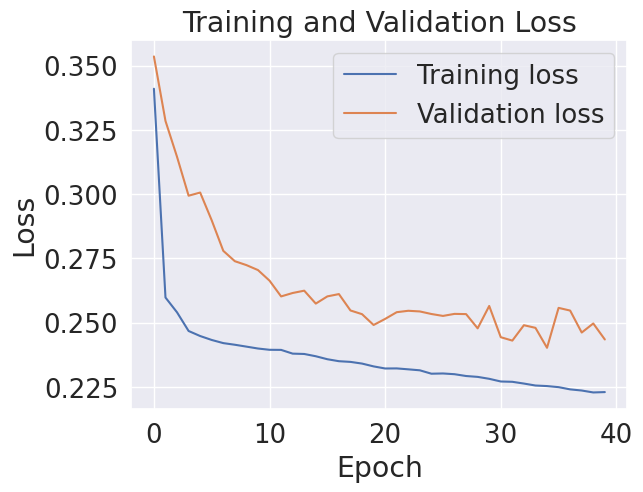

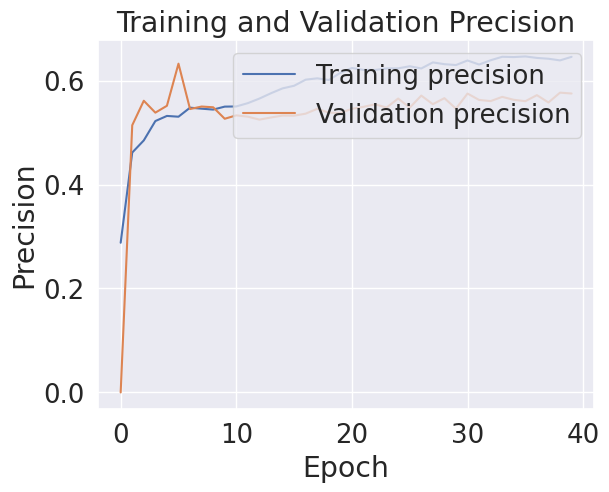

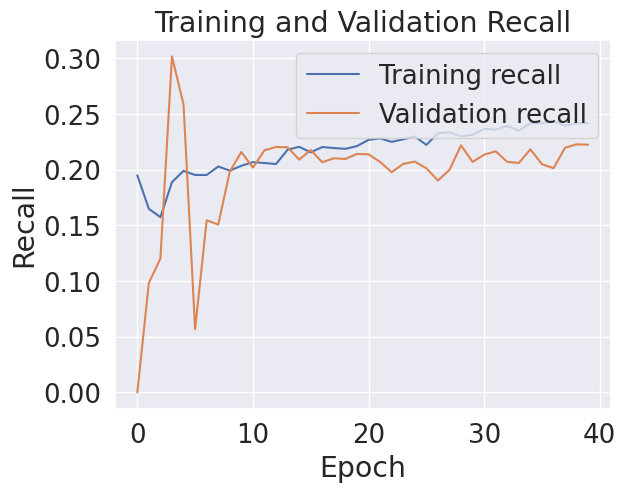

In [ ]:
# CodeGrade Tag Ex4a


# Function to plot training and validation metrics
def plot_metrics(metric_name, title, xlabel, ylabel, legend_loc='upper right'):
    plt.plot(history.history[metric_name], label='Training ' + metric_name)
    plt.plot(history.history['val_' + metric_name], label='Validation ' + metric_name)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=legend_loc)
    plt.show()

# Set seaborn font scale
sns.set(font_scale=1.7)

# Plot training and validation loss
plot_metrics('loss', 'Training and Validation Loss', 'Epoch', 'Loss')

# Plot training and validation precision
plot_metrics('precision', 'Training and Validation Precision', 'Epoch', 'Precision')

# Plot training and validation recall
plot_metrics('recall', 'Training and Validation Recall', 'Epoch', 'Recall')


**Load the best weights from your model checkpoint, and create plots demonstrating the classification perfomnce of the model. Be sure to demonstrate the results of the multi-label classification, comparing the top three most probable genres predicted with the ground truth genres for each poster. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

23/23 [==============================] - 0s 15ms/step


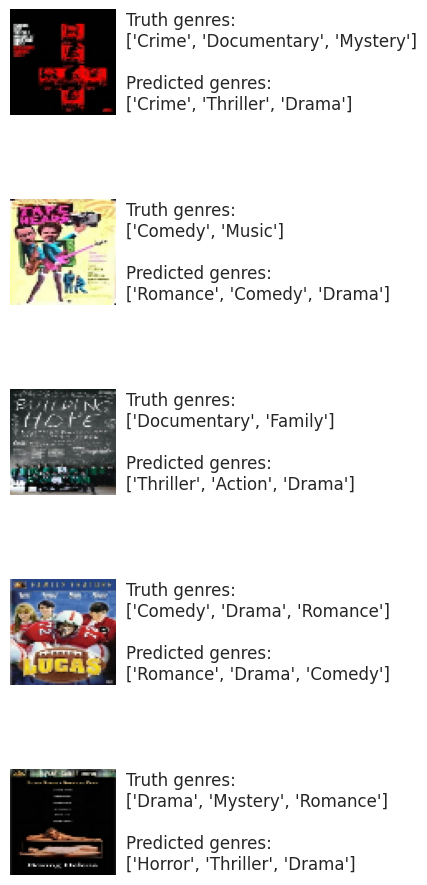

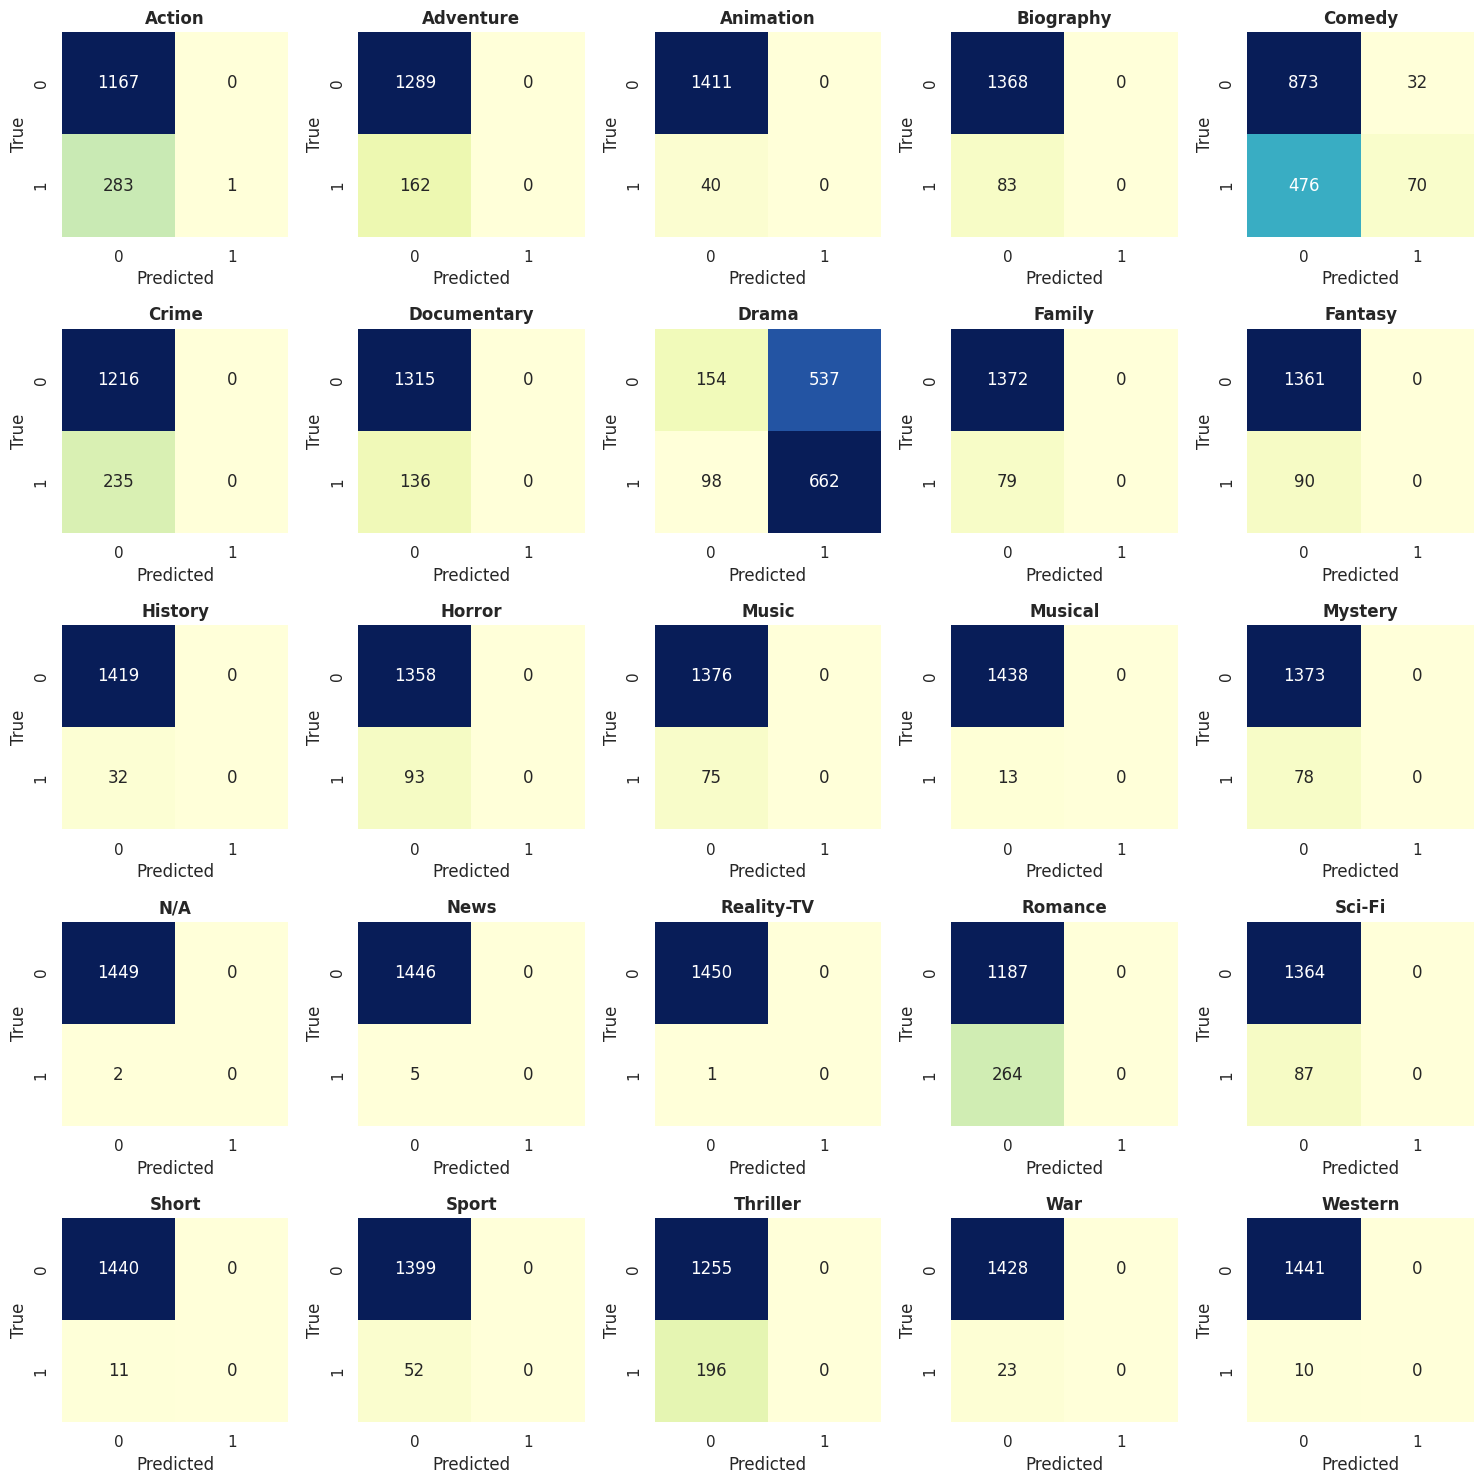

/tmp/ipykernel_10197/802931985.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts_sorted.index, y=genre_counts_sorted.values, palette="viridis")


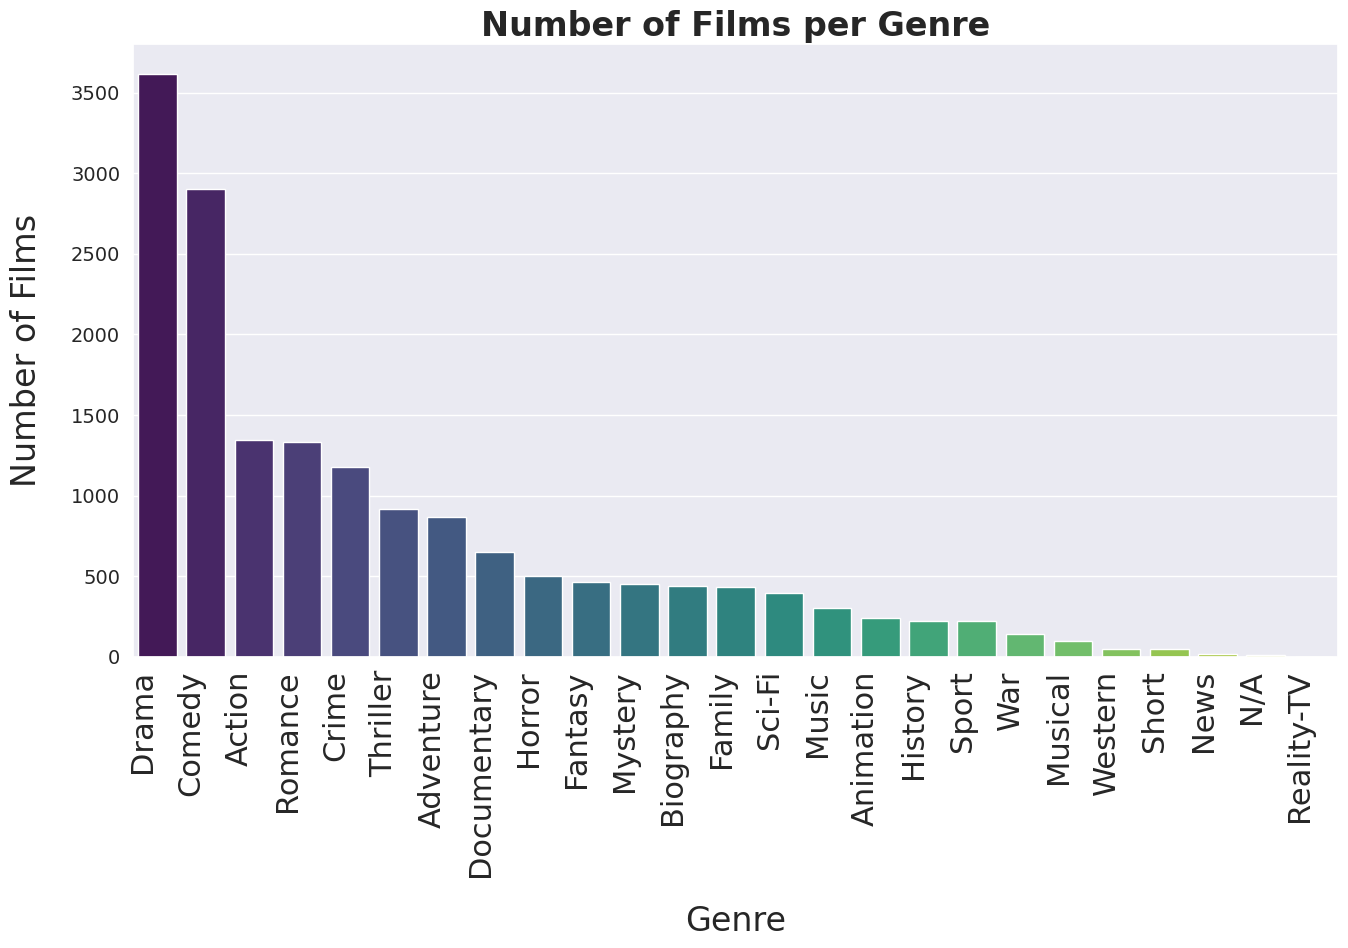

In [ ]:
# CodeGrade Tag Ex4b

# Load the best weights from the model checkpoint
model.load_weights(checkpoint_filepath)


# Function to plot images with predicted and true labels
def plot_images_with_predictions(image_batch, labels_batch, predictions, class_names, num_samples=5):
    sns.set(font_scale=1)
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 10))
    fig.tight_layout(pad=3.0)

    for i in range(num_samples):
        ax = axes[i]
        img = (image_batch[i] * 255).numpy().astype("uint8")
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        true_labels = [class_names[j] for j in range(len(class_names)) if labels_batch[i, j] == 1]
        pred_labels = np.argsort(predictions[i])[-3:]
        pred_names = [class_names[pred] for pred in pred_labels]
        text = f"Truth genres:\n{true_labels}\n\nPredicted genres:\n{pred_names}"
        ax.text(1.1, 0.5, text, transform=ax.transAxes, fontsize=12, verticalalignment='center')
        ax.axis('off')

# Function to plot confusion matrix
def plot_confusion_matrix(predictions, labels_test, genres):
    binary_predictions = (predictions > 0.5).astype(int)
    binary_ground_truth = labels_test.astype(int)
    conf_matrix = multilabel_confusion_matrix(binary_ground_truth, binary_predictions)
    num_classes = len(genres)
    num_plots_per_row = 5
    num_rows = (num_classes - 1) // num_plots_per_row + 1

    plt.figure(figsize=(15, 3*num_rows))

    for i in range(num_classes):
        plt.subplot(num_rows, num_plots_per_row, i+1)
        plt.subplots_adjust(hspace=0)
        sns.heatmap(conf_matrix[i], annot=True, cmap='YlGnBu', fmt='d', cbar=False)
        plt.title(genres[i], weight='bold')
        plt.xlabel('Predicted')
        plt.ylabel('True')

    if num_classes % num_plots_per_row != 0:
        for i in range(num_classes % num_plots_per_row, num_plots_per_row):
            plt.delaxes(plt.gca())

    plt.tight_layout()
    plt.show()

# Function to plot number of films per genre
def plot_genre_counts(genre_counts_sorted):
    sns.set(font_scale=2)
    plt.figure(figsize=(14, 10))
    sns.barplot(x=genre_counts_sorted.index, y=genre_counts_sorted.values, palette="viridis")
    plt.title('Number of Films per Genre', weight='bold')
    plt.xlabel('Genre', labelpad=20)
    plt.ylabel('Number of Films',  labelpad=20)
    plt.xticks(rotation=90, ha='right')
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

# Use the trained model to predict genres for the test dataset
predictions = model.predict(mv_val_ds)

# Plot predictions with true labels
image_batch, labels_batch = next(iter(mv_val_ds.take(1)))
plot_images_with_predictions(image_batch, labels_batch, predictions, genres)

# Plot confusion matrix
plot_confusion_matrix(predictions, labels_test, genres)

# Summing up the number of films per genre
genre_counts = dataset.iloc[:, 2:].sum()
genre_counts_sorted = genre_counts.sort_values(ascending=False)

# Plot number of films per genre
plot_genre_counts(genre_counts_sorted)